In [1]:
import torch
import random
import sys
sys.path.append('../.')
sys.path.append('../../.')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

**Load data**

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

dataset = 'ecoli_prior'
X = pd.read_csv('../data/ecoli.csv')
ind = list(range(len(X.columns)))
col_list = X.columns[ind]
ct = ColumnTransformer([('scaler', StandardScaler(), col_list)], remainder='passthrough')

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,eutG,sucA,atpG,flgD,sucD,yhdM,dnaJ,gltA,b1191,ygcE,...,pspA,nmpC,yheI,ycgX,dnaG,folK,b1963,dnaK,mopB,ftsJ
0,-0.027759,0.122599,0.264658,0.153671,-0.043405,-0.542246,0.619729,0.084389,-0.033762,0.077002,...,-1.156587,1.542883,-0.043889,-0.338571,-0.430860,-0.336886,-0.222453,0.315515,0.629529,0.488032
1,0.645966,-1.182445,-0.297893,-0.958127,-1.348025,0.239957,0.669959,-2.574957,-1.916479,-2.269440,...,0.473894,-0.614861,-2.270004,-1.746693,-1.686743,-2.147293,-2.143699,-2.509647,-2.754116,-2.406968
2,-0.878432,0.415826,-0.418150,0.188152,0.720372,-0.339575,0.828943,0.127842,1.275507,1.133740,...,1.014847,-1.652255,0.251795,0.320190,0.420012,0.150618,-0.217249,0.413813,0.236786,-0.205489
3,-0.458864,0.296419,0.381965,-0.282977,1.698835,0.027809,-1.067956,-2.038131,-0.197604,-0.155425,...,-0.401261,1.322398,-0.196608,-0.457251,-0.027710,-0.278149,0.004377,-0.212255,-0.489394,-0.719893
4,-0.687974,0.685775,0.989306,0.398356,1.347598,-1.213816,-0.896065,-0.525506,-0.363537,0.036631,...,2.540371,-1.535672,-1.128562,-0.764837,-1.085189,-1.031513,-1.461310,-1.059138,-0.743434,-0.567452


**Load prior knowledge**

In [3]:
adj_mat_100 = pd.read_csv('../data/ecoli_adj_matrix.csv', index_col=0).values
adj_mat_50 = adj_mat_100.copy()
for i in range(adj_mat_50.shape[0]):
    for j in range(adj_mat_50.shape[1]):
        if adj_mat_50[i][j] == 1:
            if random.random() < 0.5:
                adj_mat_50[i][j] = 0

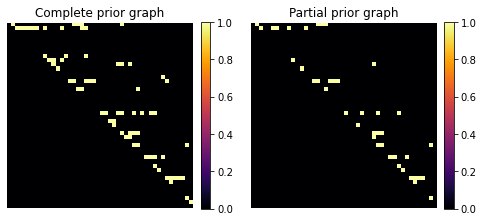

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax1, ax2 = axes
im1 = ax1.imshow(adj_mat_100, cmap='inferno', interpolation='nearest', vmin=0, vmax=1.0)
fig.colorbar(im1, fraction=0.046, pad=0.04, ax=ax1)
ax1.set_title('Complete prior graph')
ax1.axis('off')

im2 = ax2.imshow(adj_mat_50, cmap='inferno', interpolation='nearest', vmin=0, vmax=1.0)
plt.colorbar(im2, fraction=0.046, pad=0.04, ax=ax2)
ax2.set_title('Partial prior graph')
ax2.axis('off')
fig.show()

**Fit model - prior knowledge**

In [5]:
from sklearn.model_selection import train_test_split
from GoggleModel import GoggleModel

In [6]:
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)
adj_mat_0 = None

for prior in [adj_mat_0, adj_mat_50, adj_mat_100]:
    if prior is None:
        graph_prior = None
        prior_mask = None
    else:
        graph_prior = torch.Tensor(prior)
        prior_mask = torch.Tensor(prior)
        
    gen = GoggleModel(
        ds_name=dataset,
        input_dim=X_train.shape[1],
        encoder_dim=64,
        encoder_l=2,
        het_encoding=True,
        decoder_dim=64,
        decoder_l=1,
        threshold=0.1,
        decoder_arch='gcn',
        graph_prior=graph_prior,
        prior_mask=prior_mask,
        device='cuda',
        beta=1,
        learning_rate=0.01,
        seed=0
    )
    gen.fit(X_train)
    X_synth = gen.sample(X_test)
    X_synth.head()
    res = gen.evaluate_synthetic(X_synth, X_test)
    print(f'Quality: {res[0]:.3f}')
    print(f'Detection: {res[2]:.3f}')
    print(f'Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}')

[Epoch 100/1000, patience  3] train: 13.907, val: 15.050
[Epoch 200/1000, patience  6] train: 11.194, val: 11.585
[Epoch 300/1000, patience  0] train: 9.991, val: 10.209
[Epoch 400/1000, patience  3] train: 9.389, val: 9.749
[Epoch 500/1000, patience  9] train: 9.313, val: 9.483
[Epoch 600/1000, patience 45] train: 8.935, val: 9.520
Training terminated after 604 epochs
Evaluating regression performance...
Evaluating regression performance...
Evaluating regression performance...
Quality: 0.599
Detection: 0.732
Performance on real: 0.148, on synth: 7.928
[Epoch 100/1000, patience  2] train: 13.905, val: 15.238
[Epoch 200/1000, patience  4] train: 10.938, val: 11.152
[Epoch 300/1000, patience  1] train: 9.245, val: 9.616
[Epoch 400/1000, patience  3] train: 8.919, val: 9.197
Training terminated after 446 epochs
Evaluating regression performance...
Evaluating regression performance...
Evaluating regression performance...
Quality: 0.617
Detection: 0.709
Performance on real: 0.148, on synth: